# sentiment analysis

In [1]:
import re
import numpy as np
import pandas as pd
import csv
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer #for text
#from tensorflow.keras.preprocessing.image # for image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

### Load dataset

In [3]:
# df = pd.read_csv("SentimentDatasets.csv")
# display(df.head()) 

column_names = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
datasets_encoding = 'ISO-8859-1'

df = pd.read_csv("SentimentDatasets.csv", 
                      encoding=datasets_encoding, 
                      names = column_names)
#df=df[:500]
#df = df.sample(n=1000)

display(df.head()) 
print(df.shape)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


(1600000, 6)


In [4]:
df['text'][0:6]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
Name: text, dtype: object

In [5]:
# drop unnecessary columns
df = df.drop(['ids', 'date', 'flag', 'user'], axis=1)
df.tail(3)

,sentiment,text
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity...


In [18]:
print(df['sentiment'].unique())

# make it 0 and 1 
#replace 0 with 0 and 4 with 1
df['sentiment']=df['sentiment'].replace(4,1)
print(df['sentiment'].unique())

[0 1]
[0 1]


In [7]:
df['sentiment'].value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

#### Note: equal number of 0= negative,1=positive sentiment

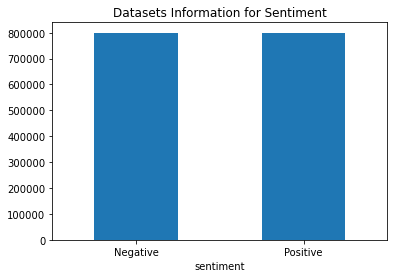

In [8]:
ax = df.groupby('sentiment').count().plot(kind = 'bar',
                                               title = "Datasets Information for Sentiment", 
                                               legend = False)
ax.set_xticklabels(["Negative", "Positive"], rotation = 0)
plt.show()

### preprocessing

In [9]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [10]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [11]:
def preprocessData(textdata):
    
    processText = []
    wordLEM = WordNetLemmatizer() #lemmatization
    

    urlpattern = r'((https://)[^ ]*|(http://)[^ ]*|(www\.)[^ ]*)'  # URL
    userPattern = '@[^\s]+'  # hastag user
    alphaPattern = '[^a-zA-Z0-9]' #alphaneumaric
    sequencepattern = r'(.)\1\1+' 
    seqReplace = r'\1\1'
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(urlpattern, " URL", tweet) # replace URL link with URL word

        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "Emoji"+emojis[emoji]) # replace emojis with emoji+ emotion word
            
        
        tweet = re.sub(userPattern, " User", tweet) # replace user tag with user word
        tweet = re.sub(alphaPattern, " ", tweet) # replace user tag with blank
        tweet = re.sub(sequencepattern, seqReplace, tweet)
        
        tweetwords = ""
        for word in tweet.split():
            if len(word) > 1:
                word = wordLEM.lemmatize(word)
                tweetwords += (word+' ')
                
        processText.append(tweetwords)
        
    return processText

In [12]:
import nltk
#nltk.download()
from nltk.corpus import wordnet

In [13]:
import time
t = time.time()
processedtext = preprocessData(df['text'])
print(round(time.time() - t))
#processedtext

105


In [14]:
df_neg=processedtext[:80000]
df_pos=processedtext[80000:]

### word cloud for negative words

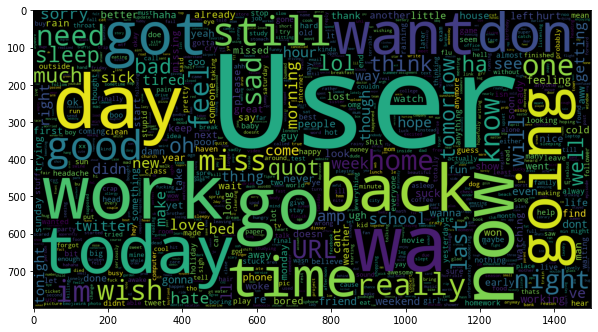

In [15]:
plt.figure(figsize = (10, 8))
wc = WordCloud(max_words=1000, 
              width = 1500,
              height = 800, 
              collocations = False).generate(" ".join(df_neg))
plt.imshow(wc)
plt.show()

### wordcloud for positive words

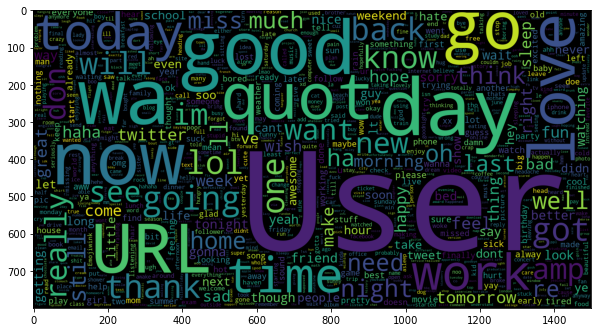

In [16]:
plt.figure(figsize = (10, 8))
wc = WordCloud(max_words=1000, 
              width = 1500,
              height = 800, 
              collocations = False).generate(" ".join(df_pos))
plt.imshow(wc)
plt.show()

In [22]:
df.head()
x=df['text']
y=df['sentiment']

In [23]:
x_train, x_test, y_train , y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, random_state = 0)

In [20]:
x_train, x_test, y_train , y_test = train_test_split(processedtext, 
                                                    sentiment, 
                                                    test_size = 0.2, random_state = 0)

NameError: name 'sentiment' is not defined